In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from numpy.linalg import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
# параметры распределений
mu0 = np.array([-2.,1.])
mu1 = np.array([3.,-0.5])

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0.data), torch.eye(2))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1.data), torch.eye(2))

In [5]:
d0.sample((10,))

tensor([[-0.5722,  1.8333],
        [-1.3122,  0.9057],
        [-1.1641,  1.3858],
        [-1.1173,  1.0157],
        [-1.5082,  1.5637],
        [-0.7924,  0.8553],
        [-2.7417,  1.2811],
        [-2.3930,  2.0499],
        [-2.4548, -0.5372],
        [-3.5062,  2.2005]])

In [6]:
d1.sample((10,))

tensor([[ 2.5969, -1.0240],
        [ 2.7502,  0.0374],
        [ 2.6328, -0.5368],
        [ 2.9000, -0.5582],
        [ 1.3463,  0.2538],
        [ 2.3516,  0.0439],
        [ 2.6698,  1.0390],
        [ 2.9878, -0.5825],
        [ 2.6773,  0.5398],
        [ 1.9930, -1.3620]])

In [7]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([ 0.3932, -0.0153]), tensor(0.6510)]


In [8]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.397746
Ошибка после 1 итераций: 0.253566
Ошибка после 2 итераций: 0.189815
Ошибка после 3 итераций: 0.154398
Ошибка после 4 итераций: 0.131981
Ошибка после 5 итераций: 0.116573
Ошибка после 6 итераций: 0.104998
Ошибка после 7 итераций: 0.095203
Ошибка после 8 итераций: 0.088462
Ошибка после 9 итераций: 0.082397
Ошибка после 10 итераций: 0.076815
Ошибка после 11 итераций: 0.073128
Ошибка после 12 итераций: 0.069728
Ошибка после 13 итераций: 0.065813
Ошибка после 14 итераций: 0.063187
Ошибка после 15 итераций: 0.061112
Ошибка после 16 итераций: 0.059643
Ошибка после 17 итераций: 0.057131
Ошибка после 18 итераций: 0.054750
Ошибка после 19 итераций: 0.053375


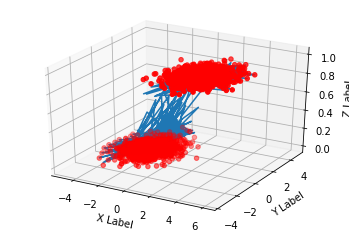

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
x, y = sample(d0, d1, 1024)
with torch.no_grad():
    dist = torch.sigmoid(layer(x)).numpy()
ax.scatter(xs=x[:,0], ys=x[:,1], zs=y, c='r')
ratio = x[:,1].numpy() / (x[:,0].numpy() + x[:,1].numpy())
ax.plot(x[:,0].numpy(), x[:,1].numpy(), zs=dist.flatten(), label='pred')